In this practical session, we explore the use of the Laplacian operator on a surface, in order to solve heat diffusision, to perform shape matching, or even to compute geodesic distances !

In a first step, we learn how to read and store triangulated surfaces (*meshes*), and how to build the discrete Laplace-Beltrami Operator. 

We then seek to use this operator in different practical scenarios.

# Setup envionment 

Your Python environment should include `numpy`, `scipy`, `matplotlib` and `meshplot`. The latter can be installed from conda using:
><code> conda install -c conda-forge meshplot
</code>

Please download [this zip file](https://www.lix.polytechnique.fr/Labo/Robin.Magnet/INF631/data.zip) and place all elements in the same folder as the notebook.

In [1]:
import numpy as np
import scipy.sparse as sparse


# If you did not put the elements of the zip file in the same folder as the the notebook add the next two lines
# import sys
# sys.path.append("PATH TO THE DIRECTORY WHERE YOU UNZIPED YOUR FILES")
import plot_utils as plu # Follow the above procedure

# 0. Reading and storing a mesh 

Unlike images, there are several ways to represent a discrete (triangulated) surface. In this session, we will stick to the most basic data structure which is made of:
1. A list of vertex coordinates in $\mathbb{R}^3$
2. A list of triangles, each defined by 3 **ordered** vertex indices $i,j,k\in\mathbb{N}$. The order of the vertices define the direction of the normal.

The `OFF` format, or **O**bject **F**ile **F**ormat, stores this information in a `.off` file, which we will use today. 

Open the `bunny.off` file using a text editor, where the structure will look like :
<blockquote>
    <code>OFF
34834 69451 0
-0.0378297 0.12794 0.00447467
-0.0447794 0.128887 0.00190497
...
-0.0400442 0.15362 -0.00816685
3 20463 20462 19669 
3 8845 8935 14299 
...</code>
</blockquote>

As you may already understand, our `.off` file is presented as follows:
<ol>
    <li> First Line: <code>OFF</code> letters</li>
    <li> Second Line:  <code>n m 0</code>, with $n$ the numbers of <b>vertices</b> and $m$ the number of <b>triangles</b></li>
    <li> Next $n$ lines: <code>X Y Z</code> coordinates for each <b>vertex</b></li>
    <li> Next $m$ lines: <code>3 i j k</code> indices of the vertices constituting each <b>face</b></li>
</ol>

In practice, the `OFF` file format can include some more information as you can see on [here](https://en.wikipedia.org/wiki/OFF_(file_format)) if you are interested.

### QUESTION 1
<b> Write the function `read_off` which can read a basic `.off` file.</b>

**Tips** :
<ol>
    <li> You can use the <code>with</code> statement to efficiently process a file: <br>
        <code>with open(filepath, 'r') as f:
   # compute operation on file</code>
    </li>
    <li> <code>f.readline()</code> returns the next line</li>
    <li> <code>text.strip().split()</code> removes breakline characters from <code>text</code> and splits with respect to spaces. Try it with <code>text="1 2 3\n"</code> to see what happens.</li>
</ol>

In [12]:
def read_off(filepath):
    """
    Reads a simple .off file
    
    Input
    --------------
    filepath : str - path to the .off file
    
    Output
    --------------
    vertices : (n,3) array of vertex coordinates (float)
    faces    : (m,3) array of faces defined by vertices index (integers)
    """
    ## TODO
    # READ THE OFF FILE with path "filepath" and return vertex and faces information
    with open(filepath, 'r') as f:
        f.readline()
        params = f.readline().strip().split()[:-1]
        n, m = (int(p) for p in params)

        vertices, faces = [], []

        vertices = np.array([[float(p) for p in f.readline().strip().split()] for _ in range(n)])
        faces = np.array([[int(p) for p in f.readline().strip().split()[1:]] for _ in range(m)])        
      
    return vertices, faces

In [13]:
vertices, faces = read_off('bunny.off')
vertices.shape, faces.shape

((34834, 3), (69451, 3))

As we will have to deal with several components regarding a single mesh, it might be good to create a specific class in which all information will be stored.

In [14]:
class MyMesh:
    def __init__(self, path):
        """
        Initialize the mesh from a path
        """
        self.vertices, self.faces = read_off(path)

This way, if we define an instance of `MyMesh` as `mesh = MyMesh(filepath)`, the `__init__` function is automatically run with parameter `filepath` (ignore the `self` parameter).

Then the mesh vertex coordinates can be accessed using `mesh.vertices`and its faces information with `mesh.faces`. These are the *properties* of our class.

Let us load and visualize our bunny:

In [15]:
mesh = MyMesh('bunny.off')

In [16]:
plu.plot(mesh)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

# 1. Discrete Operators

As seen in class, the Laplacian of a mesh is ubiquitous in geometry processing. The discrete laplacian is defined as
$$
L = A^{-1}W
$$
with $A$ the (diagonal) area matrix, and $W$ the cotangent weight matrix

**Notes for Sparse Matrices**<br>
As the Laplace-Operator is a differential operator, it only locally acts at a point with respect to a local neighborhood. When storing it in a $n\times n$ matrix, this results in numerous zero entries, which are useless to keep in memory.

For both speed and memory efficiency, we use sparse matrices to represent such operators, where only non-zero entries are stored. The most basic structure for a sparse matrix is the **COO**rdinate format, which consists in three lists $I,J,V$ which respectively store the line index, column index and value for each non-zero entry.

For algebra manipulations (matrix vector multiplications, linear system, ...), other format such as **C**ompressed **S**parse **R**ow (CSR) provide a substential speedup compared to COO. You can read about the CSR and CSC format [here](https://en.wikipedia.org/wiki/Sparse_matrix).

In the [`scipy.sparse`](https://docs.scipy.org/doc/scipy/reference/sparse.html) library, you can generate COO, CSR or CSC matrices from the $I,J,V$ format using for instance<br>
> <code>scipy.sparse.csr_matrix((V, (I,J)), shape=(N,N))</code>

Note that depending on your python version, you might now have access to the more recent `scipy.sparse.csr_array` functions.

**Notes for numpy linear algebra**<br>
A few tips for simpler reading of numpy
<ol>
    <li> <code>np.matmul(A, B)</code> and <code>A @ B</code> are the same </li>
    <li><code>np.matmum(A, v)</code> and <code>A @ v</code> are the same</li>
    <li><code>np.dot(u, v)</code> and <code>u @ v</code> are the same</li>
    <li> <code>np.transpose(A)</code> and <code>A.T</code> are the same</li>
</ol>

This means <code>A @ B.T @ u</code> is the same as <code>np.matmul(A, np.matmul(np.transpose(B), u))</code>

## Question 2 
<b> Fill the functions <code>compute_faces_areas</code> and <code>area_matrix</code> to respectively compute the area of each face and the vertex-wise area matrix $A$</b>

Recall the area matrix $A$ is a $n\times n$ diagonal matrix where each entry provide the corresponding vertex area defined as:
$$
A_{ii} = \frac{1}{3}\sum_{f\in\mathcal{F}\\ i\in f} \text{Area}(f)
$$

**Tip**: There are multiple ways to compute the area of a triangle $ABC$, one of them being $\frac{1}{2}\|\vec{AB}\times \vec{AC}\|$

In [17]:
def compute_faces_areas(vertices, faces):
    """
    Compute the area of each face
    
    Input
    --------------
    vertices : (n,3) - vertex coordinates
    faces    : (m,3) - faces defined by vertex indices
    
    Output
    --------------
    faces_areas : (m,) - area of each face
    """
    ## TODO
    # Compute the area of each triangle of the mesh.
    faces_areas = np.array([np.linalg.norm(np.cross(vertices[j]-vertices[i], vertices[k]-vertices[i])) for (i,j,k) in faces])

    return faces_areas    


def area_matrix(vertices, faces):
    """
    Compute the diagonal area matrix
    
    Input
    --------------
    vertices : (n,3) - vertex coordinates
    faces    : (m,3) - faces defined by vertex indices
    
    Output
    --------------
    A : (n,n) sparse matrix in DIAgonal format
    """
    #TODO
    # Compute the area of each vertex in the mesh.
    # Use the formula above.

    faces_areas = compute_faces_areas(vertices, faces)
    vertex_areas = np.zeros(vertices.shape[0])
    for face_idx in range(faces.shape[0]):
        for vertex in faces[face_idx]:
            vertex_areas[vertex] += faces_areas[face_idx]

    vertex_areas /= 3
    
    # Create a SPARSE diagonal matix from vertex areas
    N = vertices.shape[0]
    A = sparse.dia_matrix((vertex_areas, 0), shape=(N, N))
    return A


<b>Sanity Check : Verify that your total area remains the same whether you sum all face areas or the entries of the area matrix</b>

In [18]:
faces_areas = compute_faces_areas(mesh.vertices, mesh.faces)

A = area_matrix(mesh.vertices, mesh.faces)
print(A.diagonal().sum() == faces_areas.sum())

True


## Question 3

Recall the stiffness matrix $W$ is a $n\times n$ sparse matrix. There are multiple ways to compute each entry, one of them being:
$$
W_{ij} = \begin{cases}
-\sum_{k\neq i} W_{ik} \quad&\text{if}\quad i=j\\
-\frac{1}{2} \left(\cot(\alpha_{ij}) + \cot(\beta_{ij})\right)\quad&\text{if}\quad ij\in\mathcal{E}\\
0 \quad&\text{else}
\end{cases}
$$

where $\alpha_{ij}$ and $\beta_{ij}$ are the angles opposite to the edge $ij$. Note that actually $\beta_{ij}=\alpha_{ji}$. With other notations you can visualize this face on the image below

![title](https://www.researchgate.net/publication/361577236/figure/fig3/AS:1182638081617922@1658974299594/An-illustration-for-the-cotangent-weights.png)

### Question 3.1 

<b> Fill the function <code>get_cotan_weights</code> to compute the cotangent weights for each face</b>

In [19]:
def cotan_weights(vertices, faces):
    """
    Compute cotangent weights for each face. Each vertex will carry the cotan of its angle.
    
    For a face [i, j, k], the output will be [alpha_{jk}, alpha_{ki}, alpha_{ij}].
    
    Input
    ----------
    vertices : (n,3) - The vertices of the mesh
    faces : (m,3) The faces of the mesh
    
    Output
    -------
    cotan_weights : (m,3) The cotangent weights for each face
    """
    ### TODO - Compute the cotangent weights
    # This can be done in parallel using numpy, or by looping over the faces
    cotan_weights = np.zeros((faces.shape[0], 3))

    def cotan(v1, v2):
        cos = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        sin = np.sqrt(1 - cos**2)
        return cos/sin
    
    for f_idx, face in enumerate(faces):
         for i in range(3):
             v1 = vertices[face[(i+1) % 3]] - vertices[face[i]]
             v2 = vertices[face[(i+2) % 3]] - vertices[face[i]]
             cotan_weights[f_idx][i] = cotan(v1,v2)

    
    return cotan_weights

In [27]:
res = cotan_weights(mesh.vertices, mesh.faces)
np.arctan(1/res[0]).sum()

3.141592653589793

### Question 3.2 

<b> Fill the function <code>cotan_matrix</code> to compute the cotangent weight matrix $W$</b>

In [31]:
def cotan_matrix(vertices, faces):
    """
    Compute the stiffness matrix
    
    Input
    --------------
    vertices : (n,3) - vertex coordinates
    faces    : (m,3) - faces defined by vertex indices
    
    Output
    --------------
    W : (n,n) sparse matrix in CSC format
    """
    # TODO
    # Compute the entries I,J,V of the stiffness matrix
    # Note that the same pair (i,j) of indices can appear multiple times in I,J
    # The corresponding values in V are then summed by scipy
    
    cot_weights = cotan_weights(vertices, faces)
    I, J, V = [], [], []
    N = vertices.shape[0]

    def append_val(row, col, val):
        I.append(row)
        J.append(col)
        V.append(val)
    
    # i,j on the same edge
    for f_idx, face in enumerate(faces):
        for i in range(3):
            partial_cot_weight = -0.5 * cot_weights[f_idx, (i+2)%3]
            
            append_val(face[i], face[(i+1)%3], partial_cot_weight) # (i,j)
            append_val(face[(i+1)%3], face[i], partial_cot_weight) # (j,i)
            append_val(face[i], face[i], -partial_cot_weight) # (i,i)
            append_val(face[(i+1)%3], face[(i+1)%3], -partial_cot_weight) # (j,j)            
            
    W = sparse.csr_matrix((V, (I,J)), shape=(N,N))            

    return W


**Sanity Check : Ensure all terms sum to 0**

In [32]:
np.isclose(cotan_matrix(mesh.vertices, mesh.faces).sum(), 0)

True

Let us now integrate this Laplacian into our mesh class (nothing to change here):

In [33]:
class MyMesh:
    def __init__(self, path):
        """
        Initialize the mesh from a path
        """
        self.vertices, self.faces = read_off(path)
        
    def compute_laplacian(self):
        self.A = area_matrix(self.vertices, self.faces)
        self.W = cotan_matrix(self.vertices, self.faces)

The function `compute_laplacian` is called a *method* of the class `MyMesh`, and can be called as follows:

In [34]:
mesh = MyMesh('bunny.off')
mesh.compute_laplacian()

The `self` parameter actually defined the instance of the class `MyMesh` on which the method is called.
Equivalentely, one could run `MyMesh.compute_laplacian(mesh)` instead of `mesh.compute_laplacian()`.

# 2. Diffusion on Surface 

## 2.1 Exact Diffusion 

Perhaps, the most common use of the Laplace-Beltrami operator is to simulate heat diffusion on an arbitrary surface.

Recall that the Heat Equation is defined as
$$
\frac{\partial u}{\partial t} = \Delta u
$$

Given an initial function $u_0$, the values $u_t$ at time $t$ can be obtained by discretizing the equation using single backward Euler Step, which leads to 
$$
\left(I_d - t\Delta \right) u_t = u_0
$$

Note however that the mathematical laplacian $\Delta$ is <b>negative semidefinite</b>, while our laplacian $L$ is <b>positive semidefinite</b>, and $L\simeq -\Delta$. 

Replacing $\Delta$ by $-L$ and multiplying the left and right side of the equation by $A$, which removes the inverse $A^{-1}$, we obtain

$$
\left(A + tW \right) u_t = A u_0
$$

Therefore, given $u_0$, the value of $u$ at time $t$ can be obtained by solving this **sparse** linear system (as the matrix $A + tW$ we want to invert is sparse).

While the system is made of $n$ equations,  where $n$ is the number of vertices which can grow very large, the fact it is **sparse** enables the use of significanly faster solver than for dense systems of the same size. Note that solving the system **does not** require to actually invert $A + tW$.



## Question 4
<b> Fill the function <code>diffuse_full</code> to compute diffusion of an initial function $f$ for time $t$</b>

**Tip**: Use [`sparse.linalg.spsolve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.spsolve.html)

In [37]:
def diffuse_full(f, mesh, t):
    """
    Diffuse a function f on a mesh for time t
    
    Input
    --------------
    f       : (n,) - function values
    mesh    : MyMesh - mesh on which to diffuse
    t       : float - time for which to diffuse
    
    Output
    --------------
    f_diffuse : (n,) values of f after diffusion
    """
    # TODO
    # Solve the Diffusion process using the formula above
    # Assume laplcaian already computed
    f_diffuse = sparse.linalg.spsolve(mesh.A + t * mesh.W, mesh.A @ f)
    return f_diffuse

In [74]:
A.shape

(34834, 34834)

## Question 4
<b> See what happens when diffusing a dirac function</b>

**Tip**:
<ol>
    <li> Plotting the dirac function centered on index <code>ind</code> can be done with <code>plu.plot(mesh, points=ind)</code> </li>
    <li> Plotting the diffused function <code>f_diffuse</code> can be done with <code>plu.plot(mesh, f_diffuse, colormap='Reds')</code> </li>

In [173]:
## TODO
ind = np.random.randint(0, mesh.vertices.shape[0])
t = np.random.rand()

# plu.plot(mesh, points=ind)
f = np.insert(np.zeros(mesh.vertices.shape[0] - 1), ind, 1) # [0, ..., 0, 1, 0, ..., 0]
f_diffuse = diffuse_full(f, mesh, t)

plu.plot(mesh, f_diffuse, colormap='Reds')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

## 2.2 Approximate Diffusion 

As seen in class, the spectrum of the Laplace-Beltrami operator provides a functional basis which generalizes the standard Fourier Analysis to all surfaces.

As the Laplacian is only positive **semidefinite**, its spectrum is obtained by solving the **generalized** eigenvalue problem $W\phi = \lambda A \phi$.

This spectrum consists in eigenvalues - eigenfunctions pairs $\left(\lambda_j, \phi_j\right)_j$.

In practice, we only compute the first $K$ eigenfunctions where $K$ lies in $[10,100]$. This defines an **orthogonal** basis (with respect to the standard inner product defined by $A$), which already provides good approximations of many functions.

In practice, the spectrum is stored as follows:
<ol>
    <li>The eigenvalues $\left(\lambda_j\right)_j$ are stored in a list and seen as a diagonal matrix $\Lambda$</li>
    <li>The eigenvectors $\left(\phi_j\right)_j$ are stored as columns of matrix $\Phi$</li>
</ol>

and proposes the following properties:
<ul>
    <li><b>Orthogonality</b> of the inner product defined by $A$: $\Phi^\top A \Phi = I_K$. This is the discrete translation of $\langle \phi_i, \phi_j\rangle_{A} = \delta_{ij}$, where $\delta$ is here the Kronecker symbol</li>
    <li><b>Eigendecomposition</b>: $L\Phi = \Phi \Lambda$ (or $W\Phi = A\Phi \Lambda$). This is the discrete translation of $L\phi_i=\lambda_i\phi_i$</li>
    <li>The <b>projection</b> $\alpha\in\mathbb{R}^K$ of a function $f\in\mathbb{R}^n$ on the basis is: $\alpha = \Phi^\top A f$. This is the translation of $\alpha_i=\langle\phi_i, f\rangle_A$</li>
    <li>Coefficients $\alpha\in\mathbb{R}^K$ in the basis define a function $f\in\mathbb{R}^n$ on the shape as: $\Phi\alpha = f$. This is the translation of $f=\sum_{i=0}^K \alpha_i\phi_i$</li>
</ul>

Let's add the eigendecomposition of the Laplacian to the mesh class as a new method.

In [120]:
class MyMesh:
    def __init__(self, path):
        """
        Initialize the mesh from a path
        """
        self.vertices, self.faces = read_off(path)
        
    def compute_laplacian(self):
        self.A = area_matrix(self.vertices, self.faces)
        self.W = cotan_matrix(self.vertices, self.faces)
        
    def compute_eigendecomposition(self, K):
        self.eigenvalues, self.eigenvectors = sparse.linalg.eigsh(self.W, M=self.A,
                                                                  k=K, sigma=-0.01)
        # The sigma parameter allows to stabilize the eigendecomposition
        

In [219]:
mesh = MyMesh("bunny.off")
mesh.compute_laplacian()
mesh.compute_eigendecomposition(100)  ## This can take some time

## Question 6
<ol>
    <li><b> Visualize some eigenfunctios of the Laplacian.</b></li>
    <li><b> Visualize the effect of projecting a dirac function on a basis of different size</b>. Use the above explanations to project</li>
</ol>

**Tip** To plot a general function, it is good to use a simple colormap like `"coolwarm"`: <code>plu.plot(mesh, function, colormap="coolwarm")</code>

In [139]:
## TODO Plot projected dirac
modes = [10 * i for i in range(1, 10)]
for mode in modes:
    plu.plot(mesh, mesh.eigenvectors[:,mode], colormap='coolwarm')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Coming back to Diffusion, we wish to solve the Diffusion process using spectral analysis. Recall the discretized diffusion equation was
$$
\left(A + tW \right) u_t = A u_0
$$

If we consider $u_t$ to lie in a basis of size $K$ - that is $u_t =\Phi\alpha_t$, multiplying by $\Phi^\top$ on the left gives
$$
\left(I_K + t\Lambda \right) \alpha_t = \Phi^\top A u_0
$$

Since the leftmost term is diagonal, this means $u_t =\Phi\alpha_t$ with the element-wise value:
$$
(\alpha_t)_j = \frac{\beta_j}{1+\lambda_j}
$$

where $\beta=\Phi^\top A u_0$ is actually the **projection** of $u_0$ in the basis.

Note that <b>this only requires elementary matrix multiplications</b> and not solving a linear system.

**Note**: In practice we can have a better approximation by coming back to the original heat equation $\frac{\partial u_t}{\partial t} = \Delta u_t$.

Using $u_t =\Phi\alpha_t$ and $\Delta\Phi=-\Phi\Lambda$, we can obtain $\frac{\partial \alpha_t}{\partial t} = -\Lambda \alpha_t$, with $\Lambda$ being a diagonal matrix. We then obtain
$$
(\alpha_t)_j = \exp(-\lambda_j t) \beta_j
$$

## Question 7
<b> Fill the function <code>diffuse_spectral</code> which diffuses a function f for a time t</b>


In [220]:

def diffuse_spectral(f, mesh, t, k):
    """
    Diffuse a function f on a mesh for time t
    
    Input
    --------------
    f       : (n,) - function values
    mesh    : MyMesh - mesh on which to diffuse
    t       : float - time for which to diffuse
    k       : int - size of the basis to use for diffusion
    
    Output
    --------------
    f_diffuse : (n,) values of f after diffusion
    """
    # TODO
    # Solve the Diffusion process using spectral analysis.
    # Use the formula above.
    # Note that you should return the function u_t, NOT alpha_t !
    mesh.compute_eigendecomposition(k)  ## This can take some time 
    
    lamb = mesh.eigenvalues # K
    phi = mesh.eigenvectors # n*K 
    A = mesh.A # n*n
    W = mesh.W # n*n

    beta = phi.T @ A @ f # K*n @ n*n @ n -> (K,)
    alpha = np.exp(-lamb * t) * beta  

    f_diffuse = phi @ alpha    
    
    return f_diffuse

## Question 8
<b>Compare the results of the diffusion using the exact and spectral approach on :</b>
<ol>
    <li> <b>a dirac function</b>.</li>
    <li> <b> a function $\Phi\alpha$ with $\alpha\sim \otimes^k\mathcal{U}(0,1)$ </b>

Note that similarly to standard Fourier analysis, a dirac function require the entire range of frequencies to be represented in the basis.

In [249]:
## TODO
ind = 8040 # Top of the ear
k = 200
times = [0., 0.02, 0.1, 2, 30]

# dirac
f = np.insert(np.zeros(mesh.vertices.shape[0]-1), ind, 1)
for t in times:
    f_diffuse = diffuse_spectral(f, mesh, t, k)
    plu.plot(mesh, f_diffuse, colormap='coolwarm')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

In [250]:
# Function phi * alpha

mesh.compute_eigendecomposition(k) 
phi = mesh.eigenvectors
alpha = np.random.uniform(0.0, 1.0, size=k)
f = phi @ alpha

for t in times:
    f_diffuse = diffuse_spectral(f, mesh, t, k)
    plu.plot(mesh, f_diffuse, colormap='coolwarm')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016840…

# 3. The Heat Kernel Signature (Bonus, simple)

The [Heat Kernel Signature](http://www.lix.polytechnique.fr/~maks/papers/hks.pdf) (**HKS**) is a pointwise descriptor which provides local information invariant under isometry. In particular, this allows to compute correspondences between near-isometric surfaces.

Given the spectrum $\left(\lambda_j, \phi_j\right)$ of the Laplacian of a shape, the HKS is defined as
$$
HKS(x,t) = C_t\sum_j e^{-\lambda_j t} \phi_j(x)^2
$$

with $C_t^{-1} = \sum_j  e^{-\lambda_j t}$

## Question 9
<b>Fill the `compute_HKS` function to compute HKS descriptor for some time parameters $t$</b>

In [308]:
def compute_HKS(mesh, n_times, k):
    # Defines a list of time parameters at which to compute HKS
    abs_ev = sorted(np.abs(mesh.eigenvalues[:k]))
    t_list = np.geomspace(4*np.log(10)/abs_ev[-1], 4*np.log(10)/abs_ev[1], n_times)  # (n_times,)
    t_list = t_list.reshape(1, 1, -1)
    
    ## TODO COMPUTE HKS
    lamb = mesh.eigenvalues[:k].reshape(1, -1, 1)
    phi = mesh.eigenvectors[:,:k]
    
    exp = np.exp(-lamb * t_list) # (1, k, n_times)

    C = 1/np.sum(exp, axis=1).squeeze()

    HKS = C * np.sum(phi[:,:,np.newaxis]**2 * exp, axis=1) # (n, n_times)
    
    return HKS

In [309]:
HKS = compute_HKS(mesh, 100, 10)

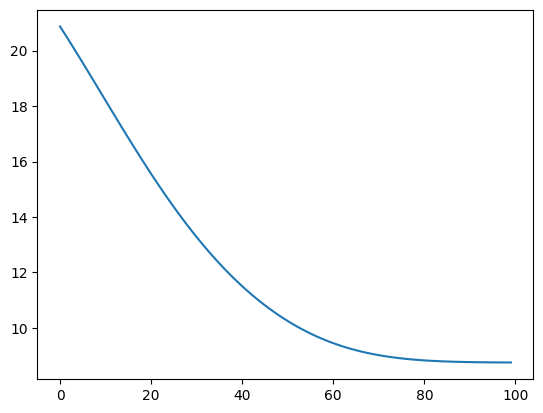

In [313]:
plt.plot(HKS[])

In [304]:
k=10
n_times=100
abs_ev = sorted(np.abs(mesh.eigenvalues[:k]))
t_list = np.geomspace(4*np.log(10)/abs_ev[-1], 4*np.log(10)/abs_ev[1], n_times)  # (n_times,)
t_list = t_list.reshape(1, 1, -1)

## TODO COMPUTE HKS
lamb = mesh.eigenvalues[:k].reshape(1, -1, 1)
phi = mesh.eigenvectors[:,:k]

exp = np.exp(-lamb * t_list) # (1, k, n_times)

HKS = np.sum(phi[:,:,np.newaxis]**2 * exp, axis=1) # (n, n_times)

HKS can later be used as a means to compute shape correspondence. Given two shapes $\mathcal{X}$ and $\mathcal{Y}$, we define the HKS distance between $x\in\mathcal{X}$ and $y\in\mathcal{Y}$ as
$$
d_{HKS}(x,y) = \int_t |HKS_\mathcal{X}(x,t) -  HKS_\mathcal{Y}(y,t)|d\log t
$$

The logarithmic sampling in `compute_HKS` naturally amounts for the $d\log t$ integration, so two embeddings obtained with our function `compute_HKS` can simply be compared using the standard norm of the difference.

Eventually, correspondences $T_{\mathcal{Y}\mathcal{X}}$ from $\mathcal{Y}$ to $\mathcal{X}$ can be obtained by setting
$$
T_{\mathcal{Y}\mathcal{X}}(y) = \underset{y\in\mathcal{Y}}{\text{argmin}}\ d_{HKS}(x,y)
$$

## Question 10
<b>Use HKS to compute correspondences between two surfaces</b>

**Tips**: 
<ol>
    <li> $T_{\mathcal{Y}\mathcal{X}}$ is stored as a $n_\mathcal{Y}$ dimensional array where the $i$-th entry gives the index of the image of $y_i$ in $\mathcal{X}$ </li>
    <li> Plot correspondences $T_{\mathcal{Y}\mathcal{X}}$ using <code>plu.plot_p2p(mesh1, mesh2, T_YX)</code></li>
    
</ol>

In [ ]:
mesh1 = MyMesh("hand1")
mesh2 = MyMesh("hand2")

# 4. Heat Method for geodesic (BONUS) 

The [Heat method](https://www.cs.cmu.edu/~kmcrane/Projects/HeatMethod/paperCACM.pdf) uses the diffusion process of a dirac function to compute geodesic distances across a mesh. One advantage of this method is speed and a formulation independant from the specific triangulation of the mesh as long as differential operators are defined (**results are not though**).

Given a point $x$, we start from a diract function $\delta_x$ centered on $x$. The heat method is solved as follows:

<ol>
    <li> Integrate the heat equation with $u_0=\delta_x$, that is solve $\left(A + tW \right) u_t = A \delta_x$. This diffuses a lot heat to points close to $x$ and the value decreases as we for further away points. </li>
    <li> Evaluate the vector field $X=-\nabla u_t / \|\nabla u_t \|$ which gives the (opposite) normalized direction of diffusion, hopefully going *geodesically* towards $x$ </li>
    <li> Solve the Poisson Equation $\Delta \varphi = \nabla\cdot X$ to obtain the geodesic distance $\varphi$ ensuring the distance to $x$ is $0$ by adding the necessary constant</li>
</ol>

The time of diffusion $t$ is usually set as $h^2$ with $h$ the average edge length of the mesh.

## Question 11 (Bonus)
**Implement the heat method usng the gradient and divergence operator we provide**

In [ ]:
def grad_f(f, vertices, faces, normals):
    """
    Compute the gradient of a function on a mesh

    Parameters
    --------------------------
    f          : (n,) function value on each vertex
    vertices   : (n,3) coordinates of vertices
    faces      : (m,3) indices of vertices for each face
    normals    : (m,3) normals coordinate for each face
    face_area : (m,) - Optional, array of per-face area, for faster computation
    use_sym    : bool - If true, uses the (slower but) symmetric expression
                 of the gradient

    Output
    --------------------------
    gradient : (m,3) gradient of f on the mesh
    """
    v1 = vertices[faces[:,0]]  # (m,3)
    v2 = vertices[faces[:,1]]  # (m,3)
    v3 = vertices[faces[:,2]]  # (m,3)

    f1 = f[faces[:,0]]  # (m,)
    f2 = f[faces[:,1]]  # (m,)
    f3 = f[faces[:,2]]  # (m,)

    # Compute area for each face
    face_areas = 0.5 * np.linalg.norm(np.cross(v2-v1,v3-v1),axis=1)  # (m)

   

    grad1 = np.cross(normals, v3-v2)/(2*face_areas[:,None])  # (m,3)
    grad2 = np.cross(normals, v1-v3)/(2*face_areas[:,None])  # (m,3)
    grad3 = np.cross(normals, v2-v1)/(2*face_areas[:,None])  # (m,3)

    gradient = f1[:,None] * grad1 + f2[:,None] * grad2 + f3[:,None] * grad3

    return gradient


def div_f(f, vertices, faces, normals, vert_areas):
    """
    Compute the divergence of a vector field on a mesh

    Parameters
    --------------------------
    f          : (m,3) vector field on each face
    vertices   : (n,3) coordinates of vertices
    faces      : (m,3) indices of vertices for each face
    normals    : (m,3) normals coordinate for each face
    vert_area : (m,) - array of per-vertex area

    Output
    --------------------------
    divergence : (n,) divergence of f on the mesh
    """
    n_vertices = vertices.shape[0]

    v1 = vertices[faces[:,0]]  # (m,3)
    v2 = vertices[faces[:,1]]  # (m,3)
    v3 = vertices[faces[:,2]]  # (m,3)

    grad1 = np.einsum('ij,ij->i', np.cross(normals, v3 - v2) / 2, f)  # (m,)
    grad2 = np.einsum('ij,ij->i', np.cross(normals, v1 - v3) / 2, f)  # (m,)
    grad3 = np.einsum('ij,ij->i', np.cross(normals, v2 - v1) / 2, f)  # (m,)

    I = np.concatenate([faces[:, 0], faces[:, 1], faces[:, 2]])  # (3*m)
    J = np.zeros_like(I)
    V = np.concatenate([grad1, grad2, grad3])

    div_val = sparse.coo_matrix((V, (I, J)), shape=(n_vertices, 1)).todense()

    return np.asarray(div_val).flatten() / vert_areas